### imports

In [153]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\fahee\AppData\Local\Temp\ipykernel_7392\909003939.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


### Create sequence data

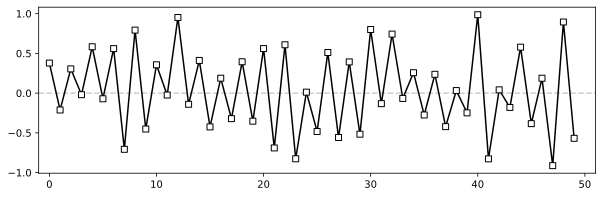

In [154]:
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1) ** i
    # if i is even, then the number is positive, otherwise it is negative

plt.figure(figsize=(10, 3))
plt.plot([-1, N + 1], [0, 0], "--", color=[0.8, 0.8, 0.8])
plt.plot(data, "ks-", markerfacecolor="w")
plt.xlim([-1, N + 1])
plt.show()

### DL model class

In [155]:
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        # RNN Layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        # run through the RNN layer
        y, hidden = self.rnn(x)  
        # no explicit hidden state initialization
        y = self.out(y)

        return y, hidden

In [156]:
# network parameters
input_size =  1 # "channels" of data (e.g., 1 for scalar timeseries, 3 for 3D data, etc.)
num_hidden =  5 # number of units in hidden layers
num_layers =  1 # number of hidden layers
seqlength  =  8 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

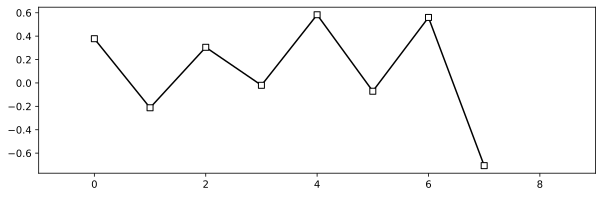

In [157]:
# plot data from beginning to segment length
plt.figure(figsize=(10, 3))
plt.plot(data[:seqlength],'ks-',markerfacecolor='w')
plt.xlim([-1,seqlength+1])
plt.show()

In [158]:
# create the network and run the data through it
net = rnnnet(input_size, num_hidden, num_layers)

X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X)
print(X.shape)
print(y.shape)
# note: we take the final output to force a "many-to-one" design.

torch.Size([8, 1, 1])
torch.Size([8, 1, 1])


In [159]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
# note: "view" is a PyTorch method that changes the shape of the tensor
# here, we're changing the shape of the tensor to match the input shape of the network
# ie, before we had a 1D tensor of length seqlength, and now we have a 3D tensor with dimensions seqlength x 1 x 1

y = net(somedata)
# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue, data[seqlength].view(1, 1))

tensor(0.4839, grad_fn=<MseLossBackward0>)

### Train the model

In [160]:
numepochs = 100

# create model and optimizer
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# train
for epochi in range(numepochs):
    seglosses = []
    segacc = []

    # initialize hidden state to zero at start of each epoch
    hidden_state = torch.zeros(num_layers, batchsize, num_hidden)

    # we will break up the data into segments of length `seqlength`
    for timei in range(N - seqlength):

        # grab a snippet of data
        X = data[timei : timei + seqlength].view(seqlength, 1, 1)
        y = data[timei + seqlength].view(1, 1)

        # forward pass and loss
        yHat, hidden_state = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

        # sign accuracy
        truesign = np.sign(torch.squeeze(y).numpy()) # get sign of true value
        predsign = np.sign(torch.squeeze(finalValue).detach().numpy()) # get sign of predicted value
        accuracy = 100 * (truesign == predsign) # check if they are the same
        segacc.append(accuracy) # store accuracy

    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)
    signaccuracy[epochi] = np.mean(segacc)

    sys.stdout.write("\r" + f"Finished epoch {epochi+1}/{numepochs}")

Finished epoch 100/100

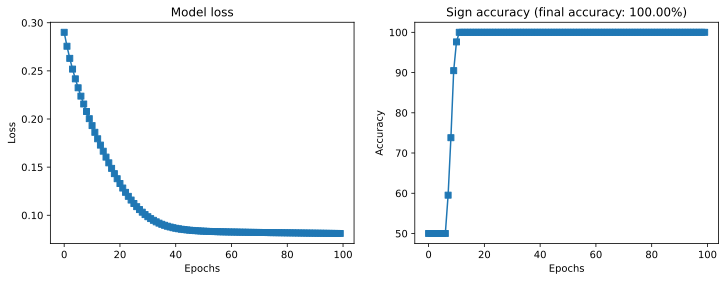

In [162]:
# plot the losses
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(losses, "s-")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(signaccuracy, "s-")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Sign accuracy (final accuracy: %.2f%%)" % signaccuracy[-1])

plt.show()

### Test the network with train data


In [140]:
# initialize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan

# loop over time segments, grabbing data, predicting, and updating state
for timei in range(N - seqlength):
    X = data[timei : timei + seqlength].view(seqlength, 1, 1)
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.detach()

# compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
# prediction only starts at seqlength, so we ignore the first segments-1 values
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])


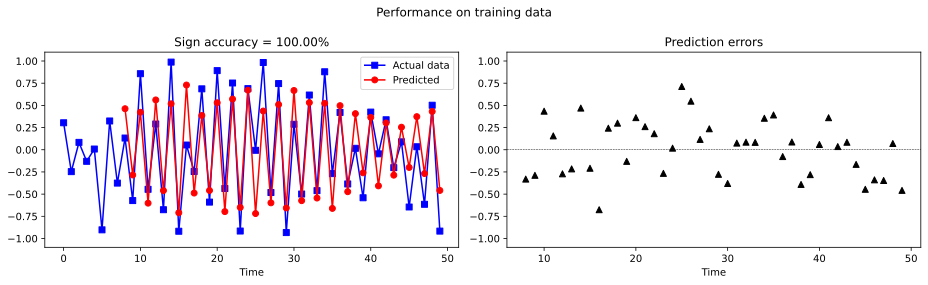

In [142]:

# plot
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(data, "bs-", label="Actual data")
ax[0].plot(yHat, "ro-", label="Predicted")
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title("Sign accuracy = %.2f%%" % signaccuracy)
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(data - yHat, "k^")
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title("Prediction errors")
ax[1].axhline(0, color="k", linestyle="--", linewidth=0.5)
ax[1].set_xlabel("Time")

plt.suptitle("Performance on training data")
plt.tight_layout()
plt.show()

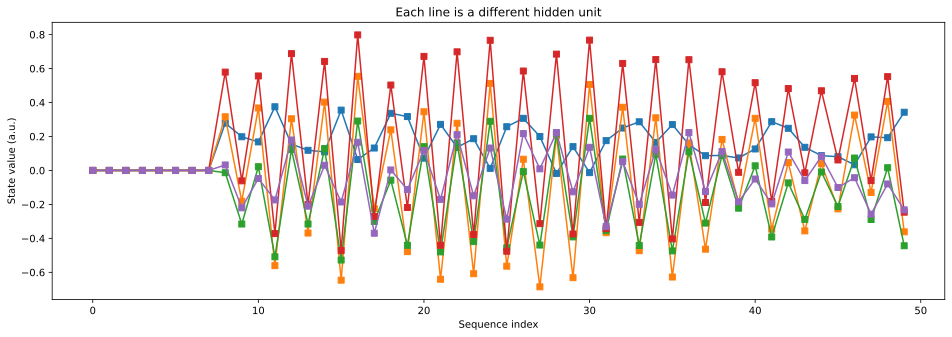

In [143]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16, 5))

plt.plot(h, "s-")
plt.xlabel("Sequence index")
plt.ylabel("State value (a.u.)")
plt.title("Each line is a different hidden unit")
plt.show()

### Test with new data

In [144]:
# Create new data WITH FLIPPED SIGNS!
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = torch.rand(1) * (-1) ** (i + 1)

In [145]:
h = np.zeros((N, num_hidden))

yHat = np.zeros(N)
yHat[:] = np.nan

for timei in range(N - seqlength):

    X = newdata[timei : timei + seqlength].view(seqlength, 1, 1)
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.detach()


# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])


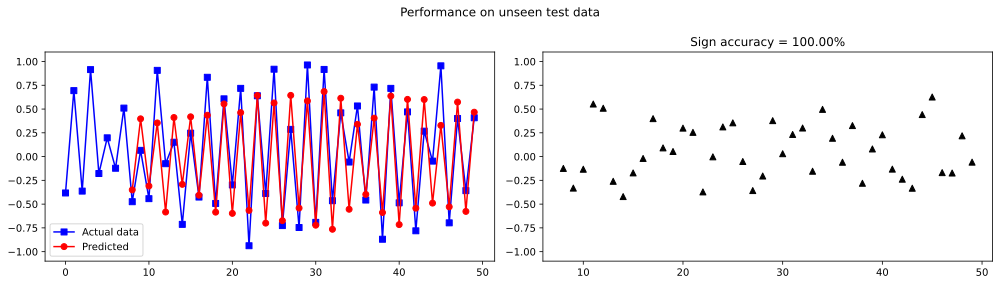

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(newdata, "bs-", label="Actual data")
ax[0].plot(yHat, "ro-", label="Predicted")
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata - yHat, "k^")
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title("Sign accuracy = %.2f%%" % signaccuracy)

plt.suptitle("Performance on unseen test data")
plt.tight_layout()
plt.show()

### Forcasting

In [147]:
# forcasting next 50 time points
newdata = torch.zeros(2 * N)
newdata[:N] = data

yHat = torch.zeros(2 * N)
yHat[:] = np.nan

for timei in range(2 * N - seqlength):
    X = newdata[timei : timei + seqlength].view(seqlength, 1, 1)
    predValue = net(X)[0][-1]
    yHat[timei + seqlength] = predValue
    if newdata[timei + seqlength] == 0:
        newdata[timei + seqlength] = predValue

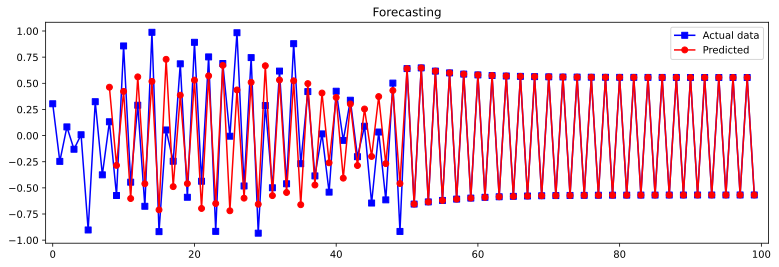

In [148]:
# plot
plt.figure(figsize=(13, 4))
plt.plot(newdata.detach(), "bs-", label="Actual data")
plt.plot(yHat.detach(), "ro-", label="Predicted")
plt.xlim([-1, 2 * N + 1])
plt.title("Forecasting")
plt.legend()
plt.show()